[Table of Contents](./table_of_contents.ipynb)

# g-h滤波器

In [1]:
from __future__ import division, print_function
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

Before we start, be sure you understand how to use [Jupyter Notebooks](http://jupyter.org/), and are familiar with the [SciPy](https://scipy.org), [NumPy](http://www.numpy.org/), and [Matplotlib](https://matplotlib.org/) packages, as they are used throughout this book. The Preface contains an introduction to these packages.

## 通过实验建立过滤的直观感觉

想象一下，我们生活在一个没有体重计的世。一天，一位同事跑到你身边，向你宣布她发明了“体重计”。在她解释之后，你急切地站在它上面宣布结果：“172磅”。你欣喜若狂——这是你生命中第一次知道你的体重。更重要的是，当您想象如果将这种设备卖给世界各地的减肥诊所的话，你简直可以数钱数到手抽筋了！ 这真是太棒了！

另一位同事听到了骚动，过来问你是什么事让你如此兴奋。你解释了这个发明，再次踏上了“体重计”，并自豪地宣布了结果：“161磅”。但是你陷入了困惑。

“它在几秒钟前显示的172磅。”你向你的第一个同事抱怨道。

“我从来没有说过这玩意是准确啊！”她回答说。

传感器并不准确。这就是要做滤波的原因，解决这个问题也是本书的主题。 我可以列出过去半个世纪以来的所提出解决方案，但这些解决方案是通过向我们所知道的知识以及我们如何知道它的本质提出非常基本问题而提出的。 在我们尝试数学方法之前，让我们按照历史的发现之旅，看看它是否能给我们建立一个对过滤的直观感觉。

**尝试其他的“体重计”**

我们有什么办法可以改善这个结果吗？ 首先要尝试的是使用更好的传感器。不幸的是，您的同事告诉您她已经构建了10个秤，并且它们的运行精度大致相同。你让她拿出另一个“体重计”，然后你分别在两个“体重计”上各测量一次。第一“体重计”（A）读数为“160磅”，第二“体重计”（B）读数为“170磅”。我们可以对你的体重得出结论了吗？

我们有哪些选择？

+ 我们可以选择只相信A，并估计我的体重为160磅。
+ 我们可以选择只相信B，并估计我的体重为170磅。
+ 我们可以选择一个比A和B都小的数。
+ 我们可以选择一个比A和B都大的数。
+ 我们可以选择一个在A和B的之间的数。

前两个选择貌似是合理的，但我们没有理由支持一个“体重计”而不是另一个“体重计”。 为什么选择相信A而不是B呢？ 我们没有理由相信。 第三和第四种选择不够理性。无可否认，这些结果都不是很准确，但根本没有理由选择超出它们所测量范围的数字。最后的选择是唯一合理的选择。 如果两个量表都不准确，并且可能会给出高于或低于我实际体重的结果，那么答案通常在A和B之间。

在数学中，这种概念被形式化表述为[*期望*](https://en.wikipedia.org/wiki/Expected_value)，我们将在以后深入介绍它。 现在问问自己，如果我们对AB测量了一百万次，那么通常会发生什么。 有些时候两次数据都太低，有时两者都太高，有时候它们又会落在实际的重量的两边。 如果他们分别落在实际重量的两边，那么我们当然应该选择A和B之间的数字。如果他们没有，那么我们不知道它们是否都太高或都太低，但是通过选择A和B之间的一个数字，我们至少可以减轻最差的那次测量的影响。 例如，假设我们的实际重量是180磅。那么160磅就存在很大的误差。但如果我们选择160磅和170磅之间的某个重量，我们的估计将优于160磅。如果两次的测量值都大于实际重量，则同样成立。

我们在后面将更正式地处理这个问题，但是现在我们希望最佳估计就是A和B的平均值。

$$ \frac{160+170}{2} = 165$$

我们可以通过图形更形象的观察。我绘制了A和B的测量值，假设每次测量的误差为±8磅之间。测量值是160和170，那么唯一合理的实际重量必然在160和170磅之间。

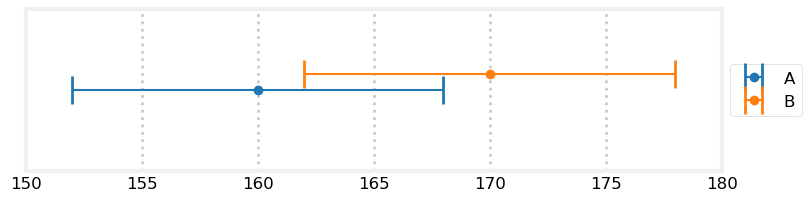

In [3]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import plot_errorbars
plot_errorbars([(160, 8, 'A'), (170, 8, 'B')], xlims=(150, 180))

A word on how I generated this plot. I import code from the module book_plots in the `kf_book` subdirectory. Generating this plot takes a lot of boilerplate Python that isn't interesting to read. I take this tack often in the book. When the cell is run `plot_errorbars()` gets called and the plot is inserted into the book.

If this is your first time using [Jupyter Notebook](http://jupyter.org/), the code above is in a *cell*. The text "In [2]:" labels this as a cell where you can enter input, and the number in the bracket denotes that this cell was run second. To run the cell, click on it with your mouse so that it has focus, then press CTRL+ENTER on the keyboard. As we continue you will be able to alter the code inside the cells and rerun them. Try changing the values "160", "170", and "10000" to some other value and run the cell. The printed output should change depending on what you entered.

If you want to view the code for plot_errorbars, either open it in an editor, or create a new cell and type the function name followed by two question marks. Press Ctrl+Enter, and your browser will open a window displaying the source code. This is a feature of Jupyter Notebooks. If you want to just view the documentation for the function, do the same but with one question mark.

```Python

    plot_errorbars??
```
or
```Python
    plot_errorbars?
```

所以165磅似乎是一个合理的估计，但从图中还有更多我们可以利用的信息。唯一可能的重量位于A和B的误差条之间的某个点。例如，161磅的重量是不可能的，因为B为170磅时，在最大误差为8磅的条件下，最小是162磅。 同样地，169磅的重量是不可能的，因为A无法满足。 在这个例子中，唯一可能的重量在162到168磅的范围内。

如果给我们更多的条件，那我们是否能找到更好的体重估计值呢？ 如果我们现在被告知A比B测量的准确三倍怎么办？ 考虑我们上面列出的5个选项。 选择A和B范围之外的数字仍然没有意义，所以我们不会考虑这些。 选择A作为我们的估计似乎更有吸引力，毕竟，我们知道它更准确，为什么不使用它而不是B？ 把B的测量值考虑进去会对A单独的测量值有提高吗？

答案也许有点有悖常理，考虑B确实会有所提升。 首先，让测量值是相同的，A=160，B=170，但A的误差为±3磅，B的误差是A的3倍，为±9磅。

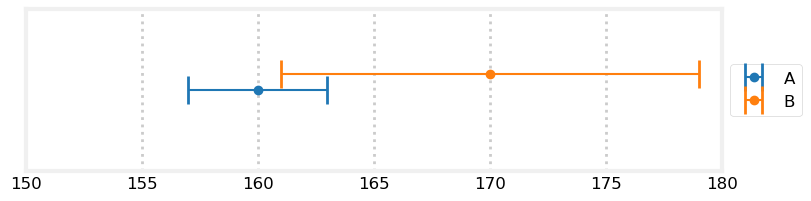

In [4]:
plot_errorbars([(160, 3, 'A'), (170, 9, 'B')], xlims=(150, 180))

A和B的误差条的重叠的部分是唯一可能的真实重量。该重叠部分小于A单独的误差。更重要的是，在这种情况下，我们可以看到重叠部分不包括160磅或165磅。因为A比B更准确，如果我们仅使用A的测量值，我们可能会得出160磅的估计值。如果我们计算A和B的平均值，我们将得到165磅的估计值。考虑到我们的秤准确性，这些重量都是不可能。通过考虑B的测量值，我们将估计值的范围缩小到了两个误差条的重叠区域，161磅到163磅之间。

让我们把它带到极限。假设我们知道A的测量精确度可以到±1磅。换句话说，如果我们真的称重170磅，真实的重量就是169,170或171磅。我们知道B的测量精确度为±9磅。 我们分别用两个“体重计”进行称重，得到A=160，B=170。那我们估计我们的体重应该是多少呢？ 让我们用图形的方式来看一下。

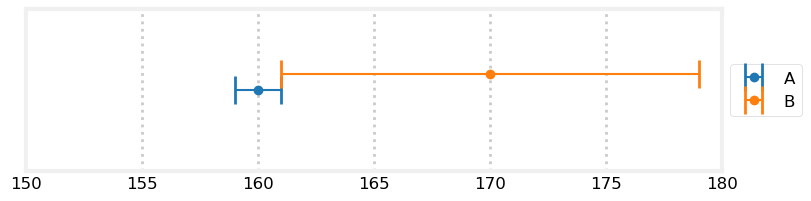

In [5]:
plot_errorbars([(160, 1, 'A'), (170, 9, 'B')], xlims=(150, 180))

通过上图，我们可以看到唯一可能的重量就是161磅。这是一个很重要的结果。使用两个相对不准确的传感器，我们就可以推断出非常准确的结果。

**因此，即使两个传感器中一个传感器不如另一个传感器精确，使用两个传感器也优于只用一个传感器。**我将在本书的其余部分为此竖起大拇指。 无论多么糟糕的数据，我们都不会丢弃信息。我们将使用数学和算法，让我们能够用上所有可能的信息，以形成可能的最佳估计。

但是，我们偏离了我们的问题。 没有客户会想要购买多个秤，而且，我们最初假设所有秤的准确度都是一样的。无论准确度如何，使用所有测量值的这种见解将在以后发挥重要作用，所以不要忘记它。

如果我只有一个秤，但我自己称重了多次，会怎么样？ 我们前面的结论是，如果我们有两个相同精度的秤，我们应该对它们的测量结果进行平均。 如果我用一个秤称自己10,000次，会怎么样？ 我们已经说过，测量值可能会会是一个太大的值，或者是一个太小的值。要证明大量重量的测量值的平均值会非常接近实际重量并不难，但让我们现在写一个模拟。I will use NumPy, part of the [SciPy](https://scipy.org/) ecosystem for numerical computation.

In [6]:
import numpy as np
measurements = np.random.uniform(160, 170, size=10000)
mean = measurements.mean()
print('Average of measurements is {:.4f}'.format(mean))

Average of measurements is 165.0040


打印的结果取决于随机数生成器，但它已经非常接近165了。

上面的代码做了一个不太正确的假设，测量的重量是在160到165之间的可能性是一样的。但现实却不是这样。真正的传感器更容易获得接近真实值的测量值，并且获得距离真实值越远的测量值的可能性越低。我们将在高斯章节中详细介绍这一点。现在，我们先不做进一步的解释，使用`numpy.random.normal()`函数将产生更多更接近165磅的值，距离165磅越远的值产生的越少。这样将产生更接近于真实情况的噪声。

In [7]:
mean = np.random.normal(165, 5, size=10000).mean()
print('Average of measurements is {:.4f}'.format(mean))

Average of measurements is 165.0454


结果就更接近165了

好了，我们现在有传感器问题的答案！但这并不是一个非常现实的答案。没有人有耐心称自己一万次，甚至十几次都不会。

那么我们需要更多的“假设”。如果你一天测量一次体重，得到170、161和169的读数，会怎么样？你长胖了还是你在减肥，或者这些只是否测量过程中的噪声呢？

这个真的不好说。 第一次测量值是170磅，最后一次测量是169磅，意味着损失了1磅。 但如果“体重计”的精确读仅有10磅，那这只能用噪音来解释。也许我的体重本来就是在增加，第一天是165磅，第三天的体重是172。那么每次体重的测量值在增加的可能性应该更大，但是“体重计”却在告诉我，我正在减肥，而我实际上体重增加了！让我们通过图表来看一下。我绘制了每次的测量值和误差线，然后用绿色虚线来表示一些重量变化的可能情况（增加或减少）。

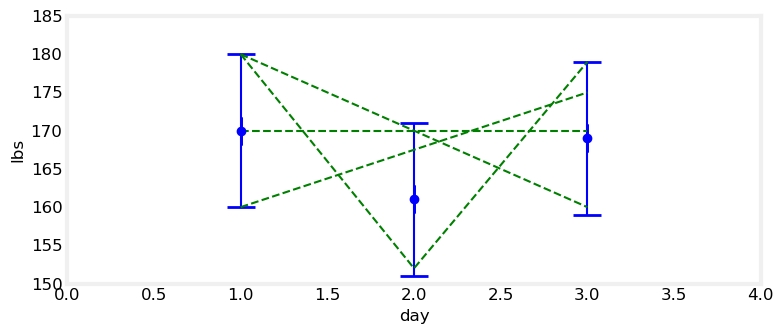

In [8]:
import kf_book.gh_internal as gh
gh.plot_hypothesis1()

从上图，我们可以看到这三次测量重量变化的极端范围。事实上，会有无数种可能性。我们只能放弃了吗？不行！回想一下，我们正在讨论的是测量人体的重量。没有合理的解释来说明，人在第1天体重是180磅，然而第3天体重变成了160磅。或者在一天内成功减掉了30磅的体重（我们假设没有截肢或发生其他创伤）。

我们所测量的物理系统的真实行为对我们解释测量值的方式是有影响的。如果我们每天称一块岩石的重量，我们将所得到方差归应该因于噪音。但如果我们称的是一个由用来接雨水并用于家务的水箱，那我觉得测量出的重量变化应该是真实的。

假设我用了另一个“体重计”，得到以下测量值：169,170,169,171,170,171,169,170,169,170。你的直觉是什么？例如说，你可能每天增加了1磅，而嘈杂的测量恰好看起来像你保持相同的重量。同样，你每天可能减掉了1磅，但是获得相同的测量值。但这可能吗？连续抛100次硬币都是正面的可能性有多大？微乎其微。我们不能仅根据这些测量值来证明我的体重似乎保持稳定。在下面的图表中，我用绘制了测量值和其误差线，并用虚线绿色绘制了可能的真实重量。这个虚线并不一定是这个问题的“正确”答案，只是一个可以通过测量测量来解释的合理可能。

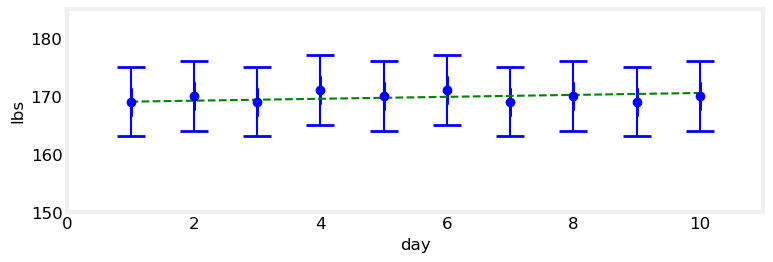

In [9]:
gh.plot_hypothesis2()

如果另一种情况能：如果测量值是158.0,164.2,160.3,159.9,162.1,164.6,169.6,167.4,166.4,171.0？ 让我们看一下下面的图表，然后尝试回答一些问题。

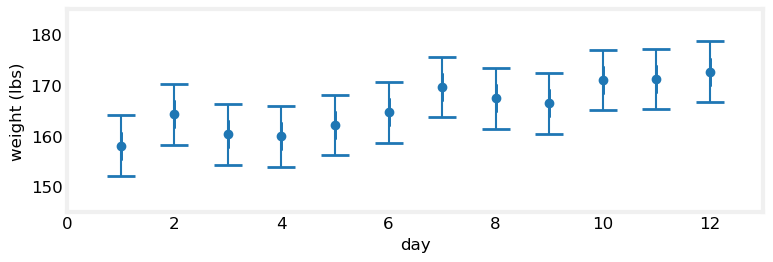

In [10]:
gh.plot_hypothesis3()

从这个图的结果我看起来是在减肥吗，或者这只是非常嘈杂的数据？显然不是。那我看起来体重是在保持稳定吗？显然也没有。这些数据随着时间推移呈现上升的趋势，虽然不均匀，但总体上是在向上增长的。我们虽然不能100%确定体重在增加，但最起码这看起来是这样的。让我们画些图来验证这个假设。通常使用图和表格更容易“观察”数据。

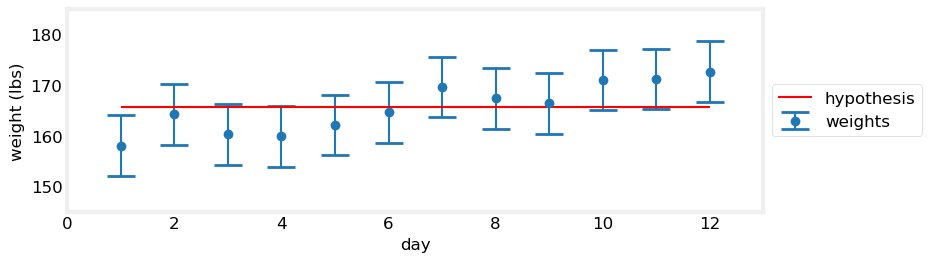

In [11]:
gh.plot_hypothesis4()

这个结果看起来并不太令人信服。实际上，从图上我们可以看到我们所绘制的水平向并没有包含在所有误差线中。

现在，让我们假设我们的体重是在增加的。增加多少？不知道，但NumPy知道！我们可以用它画出一条看起来“正确”的线。NumPy可以根据“最小二乘拟合”的规则来实现这个功能。我们先不要考虑这个算法的细节，只要绘制出结果 (I use [polyfit()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) if you are interested)。

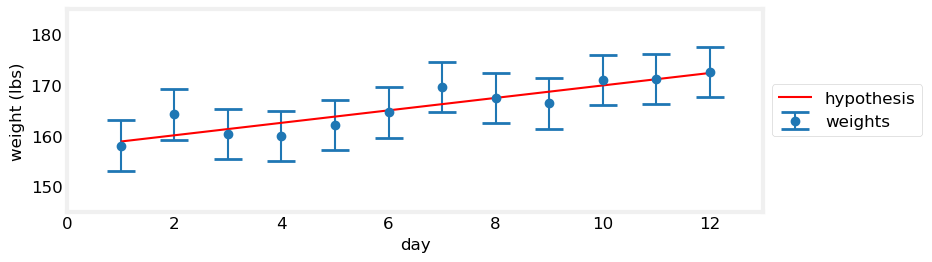

In [12]:
gh.plot_hypothesis5()

这个结果至少在我看来好多了。请注意观察图中，每个估计值与测量值都非常接近，而在之前的图中，估计值通常与测量值相差甚远。这似乎更加确信是我的体重是在增加而不是没有变化。但是我诊断增加了13磅吗？谁能保证？ 这似乎无法回答。

“但这是不可能的吗”我的同事说到。

让我们做一些更疯狂的假设。我们假设已知我每天会大约增加一磅。我怎么知道并不重要，假设我知道它大致是正确的。也许我每天摄入6000卡路里的食物，导致我的体重激增。或者可能有另一种方法来让体重增加。这只是一个实验，细节并不重要。让我们看看我们是否可以利用这些信息。

第一次测量是158。我们无法知道其他任何信息，所以让我们先接受这就是我们的估计值。 如果我们今天的体重是158，明天会是多重能？ 好吧，我们已经认为我们的体重每天会增加1磅/所以我们预测明天的体重会是159，就像这样：

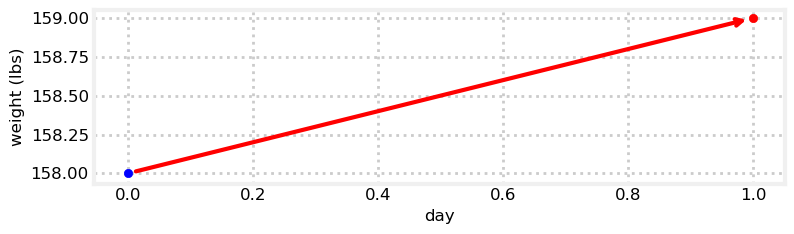

In [13]:
gh.plot_estimate_chart_1()

但这有什么用呢？ 当然，如果我们的假设每天增加1磅是准确的，并预测了未来10天的体重，但是如果我们不考虑每天的测量值，为什么还要使用秤呢？ 那么让我们来看看下一个测量。 我们再次踏上“体重计”，显示164.2磅。

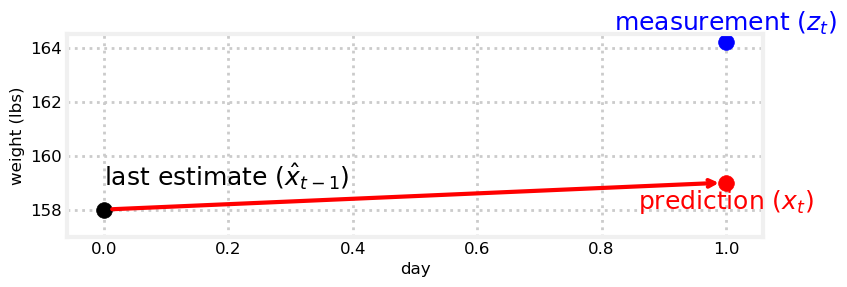

In [14]:
gh.plot_estimate_chart_2()

问题出现了。我们的预测值与测量值并不相符。但是，这就是我们希望的，对吧？ 如果预测值始终与测量值完全相同，就不需要向过滤器添加任何信息。当然，由于我们的预测值是完美的，也就没有理由进行继续测量了。

> **下一段是整本书的主要的见解。请仔细阅读！**

那么我们该怎么办？ 如果我们仅仅将测量值作为估计值，则预测值就没有意义了。如果我们只根据预测值当做估计值，那么将忽略测量值的价值。如果为了取得更好的结果，我们需要采取**某种方法综合考虑预测值和测量值**。

综合两个值——这看起来很像之前我们遇到的两个“体重计”的问题。使用与之前相同的推理，我们可以看到唯一有意义的是在预测和测量之间选择一个数字。例如，165作为估计值没有意义，157也没有。我们的估计值应该在159（预测值）和164.2（测量值）之间。

再一次强调，这一点是非常重要的。我们认为，当有两个含有误差的值时，我们应该在这两个值之间取一个估计值。这些值是如何产生的并不重要。在本章的开头我们有的两个值是测量值，但现在我们有一个测量值和一个预测值。这两种情况在数学中都是相同的。 我们**从不**抛弃信息。我是认真的。我看到许多商业软件丢掉了嘈杂的数据。不要这样做！我们对体重增加的预测值可能不是很准确，但只要有一些信息我们就应该使用它。

我认为你现在需要停下来认真地想一想。我所做的只是基于人体生理学把不准确的体重测量值换成了不准确的预测值。它仍然是数据。数学不知道这些数据是来自测量还是预测。我们有两个带有一定噪音的数据，我们希望将它们组合起来。在本书的其余部分，我们将提供一些相当复杂的数学方法来执行这个操作，但数学从不关心数据的来源，它只根据这些数值和准确性进行计算。

估计值应该在测量值和预测值之间吗？也许，但总的来说，我们似乎认为预测值要与测量的结果相比或多或少要准确一些。可能我们预测值的准确性不同于测量值的准确性。回想一下当“体重计”A比“体重计”B更准确时我们做了什么——我们将答案缩小到接近A而不是B.我们在下图中看一下。

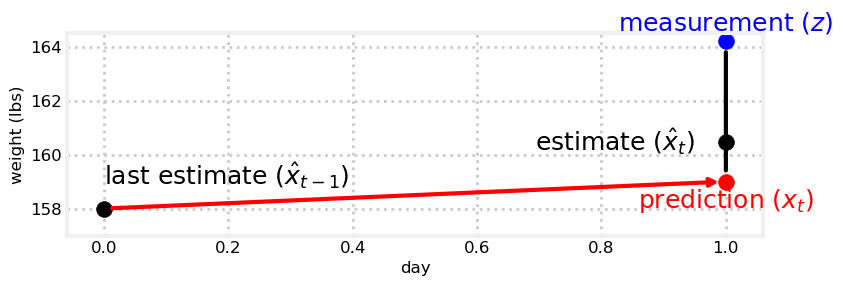

In [15]:
gh.plot_estimate_chart_3()

现在让我们尝试用一个随机选择的数字来扩展我们的估算：4/10。我们的估计值将是测量值的十分之四，其余的将来自预测值。换句话说，我们认为预测值比测量值更可能是正确的。 我们计算为：
$$ estimate = prediction+\frac{4}{10}(measurement - prediction) $$
测量值和预测值之间的差异称为残差，其由上图中的黑色垂直线描绘。这以后会使用的一个重要数值，因为它是测量值与滤波器输出之间差异的精确计算。较小的残差意味着更好的性能。

让我们根据上面的一系列权重用代码来实现并观察测试结果。我们还必须考虑另一个因素，体重增加的单位为磅/次，所以我们一般需要添加一个时间步长t，我们将其设置为1（天）。

我手动生成了对应于从160磅开始，每天增加1磅的重量数据。 换句话说，在第一天（第0天），真正的重量是160磅，在第二天（第1天，称重的第一天），真实的重量是161磅，依此类推。

我们需要假设初始重量。但现在讨论初始化策略还为时过早，所以现在我假设最初的重量为160磅。

In [16]:
from kf_book.book_plots import figsize
import matplotlib.pyplot as plt

weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 
           169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

time_step = 1.0  # day
scale_factor = 4.0/10

def predict_using_gain_guess(estimated_weight, gain_rate, do_print=False):     
    # storage for the filtered results
    estimates, predictions = [estimated_weight], []

    # most filter literature uses 'z' for measurements
    for z in weights: 
        # predict new position
        predicted_weight = estimated_weight + gain_rate * time_step

        # update filter 
        estimated_weight = predicted_weight + scale_factor * (z - predicted_weight)

        # save and log
        estimates.append(estimated_weight)
        predictions.append(predicted_weight)
        if do_print:
            gh.print_results(estimates, predicted_weight, estimated_weight)

    return estimates, predictions

initial_estimate = 160.
estimates, predictions = predict_using_gain_guess(
    estimated_weight=initial_estimate, gain_rate=1, do_print=True)     

previous estimate: 160.00, prediction: 161.00, estimate 159.80
previous estimate: 159.80, prediction: 160.80, estimate 162.16
previous estimate: 162.16, prediction: 163.16, estimate 162.02
previous estimate: 162.02, prediction: 163.02, estimate 161.77
previous estimate: 161.77, prediction: 162.77, estimate 162.50
previous estimate: 162.50, prediction: 163.50, estimate 163.94
previous estimate: 163.94, prediction: 164.94, estimate 166.80
previous estimate: 166.80, prediction: 167.80, estimate 167.64
previous estimate: 167.64, prediction: 168.64, estimate 167.75
previous estimate: 167.75, prediction: 168.75, estimate 169.65
previous estimate: 169.65, prediction: 170.65, estimate 170.87
previous estimate: 170.87, prediction: 171.87, estimate 172.16


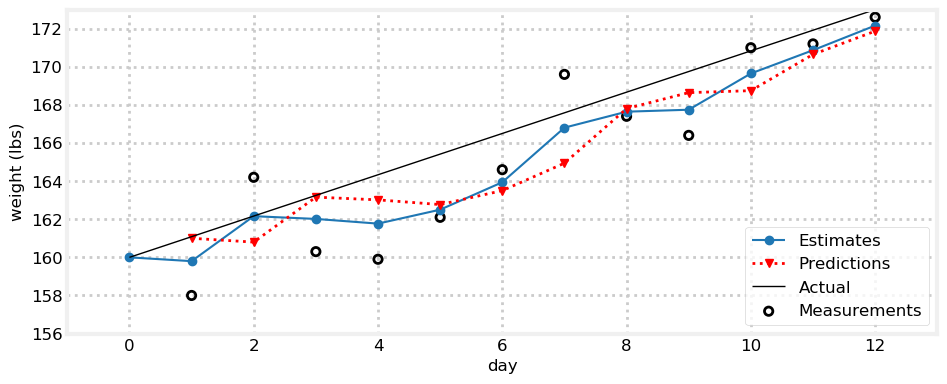

In [17]:
# plot results
book_plots.set_figsize(10)
gh.plot_gh_results(weights, estimates, predictions, [160, 173])

看起来很不错！这里有很多数据，我们来看看如何解释它们。蓝色粗线显示过滤器的估计值。它从第0天开始，初始估计值为160磅。红线显示从前一天的重量做出的预测值。因此，在第一天时，之前的重量是160磅，体重增加1磅，因此第一次预测值是161磅。第一天的估计值是预测值和测量值之间的一部分，为159.8磅。最后，细黑线表示实际增加后的体重。我们把前一天的实际重量，预测重量和每天新的估计值打印出来。

每天都要详细了解这一点，确保了解每个步骤的预测值和估计值是怎么来的。 注意估计值总是落在测量值和预测值之间。

这些估算值不是直线，但它们比测量值更直，并且更接近我们创建的真实值。而且，随着时间的推移似乎会变得越来越好。

你可能觉得过滤器的结果并不是很好。那是因为如果我们做了一个符合结论的假设，体重会按大约1磅/天增加，最终的结果数据当然看起来会很好！ 如果我们的当初的假设很糟糕，让我们看看过滤器会有什么结果。 让我们预测每天减重1磅：

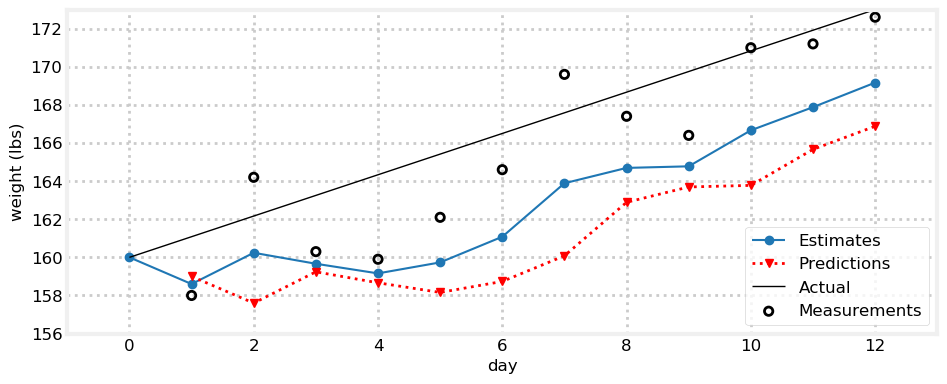

In [18]:
e, p = predict_using_gain_guess(initial_estimate, -1.)
gh.plot_gh_results(weights, e, p, [160, 173])

从图上看结果并不尽如人意。估计值很快开始偏离测量结果了。显然，要求我们正确猜测变化率的过滤器并不是很有用。 即使我们的初始值是正确的，一旦变化率发生变化，过滤器就会失败。如果我停止暴饮暴食，过滤器将很难适应这种变化。但是请注意，它正在调整！即使我们告诉它我们每天损失1磅，估计值也仍然在攀升。它只是无法快速调整。

但是，不假设一个条件我们应该怎么办呢？ 如果不假设重量将按1磅（或其他）的速率增加，而是根据现有的测量值和估计值来计算它，会怎么样。在第一天，我们对体重的估计是：
$$(160 + 1) + \frac{4}{10}(158-161) = 159.8$$
在第二天，我们测量的结果是164.2，这意味着体重增加了4.4磅（164.2-159.8=4.4），而不是1磅。我们能以某种方式使用这些信息吗？这看起来似乎是有道理。毕竟，重量测量本身是基于我们真实世界的体重测量的，所以只是有用的信息。我们对体重增加的估计可能并不完美，但肯定比我们猜测增益是1磅更好。数据优于猜测，即使它是嘈杂的。

人们往往对这一点会有疑虑，所以请确保你能认同这个观点。两次含有噪声的重量测量值给出了体重增加/减少的隐含信息。如果测量结果不准确，那么估计也将非常不准确，但此计算中仍有信息。想象一下，用一个精确度为1磅的秤来称一头牛的体重，测量结果表明奶牛体重增加了10磅。根据误差，奶牛可能已经增加了8磅到12磅，但我们知道它的体重增加了，大致增加了多少。这些都是信息。永远不要扔掉它！我们如何处理信息？

回到正题。我们应该将新增益设定为4.4磅/天吗？昨天我们认为体重增加了1磅，今天我们认为它是4.4磅。我们有两个数字，并希望以某种方式综合它们。嗯~，这听起来再次像我们遇到的同样的问题。让我们使用相同的工具，这是我们迄今为止唯一的工具——在两者之间选择一个值。这次我将使用另一个随机选择的数字$\frac{1}{3}$。由于这是一个比例（增益/天），这次的公式与前面重量估计相比，多了一个时间：

$$\text{new gain} = \text{old gain} + \frac{1}{3}\frac{\text{measurement - predicted weight}}{1 \text{ day}}$$


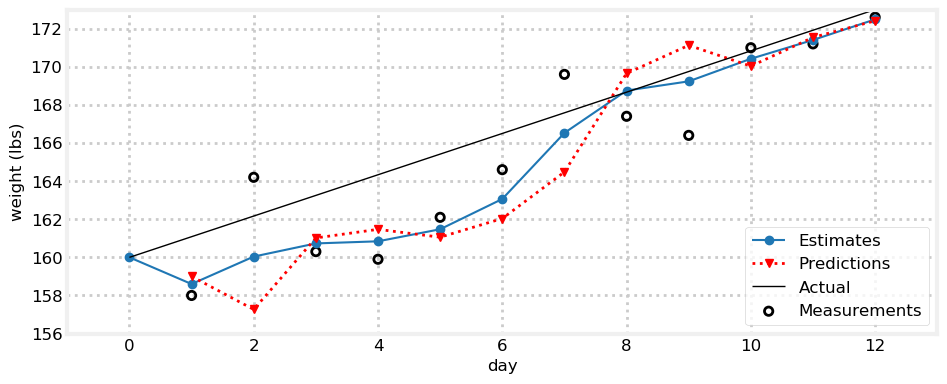

In [19]:
weight = 160.  # initial guess
gain_rate = -1.0  # initial guess

time_step = 1.
weight_scale = 4./10
gain_scale = 1./3
estimates = [weight]
predictions = []

for z in weights:
    # prediction step
    weight = weight + gain_rate*time_step
    gain_rate = gain_rate
    predictions.append(weight)
    
    # update step    
    residual = z - weight
    
    gain_rate = gain_rate + gain_scale   * (residual/time_step)
    weight    = weight    + weight_scale * residual
  
    estimates.append(weight)

gh.plot_gh_results(weights, estimates, predictions, [160, 173])

我认为这个结果看起来非常好。由于重量增益初始值为1，因此过滤器需要数天才能准确预测重量，但一旦开始，就会准确地跟踪重量的变化。我们没有使用任何方法来选择 $\frac{4}{10}$ 和$\frac{1}{3}$ 的这个两个缩放因子（实际上，它们并不是这个问题的最佳选择），但是数学的方法依然都给出了一个非常合理的假设。如果你想要逐个点查看所绘的图形，可以将参数 `time_step` 的值更改为更大的值并重新运行。

在我们继续之前，还有最后一点。在预测步骤中，我写了一行
```python
gain_rate = gain_rate
```
这显然没有效果，可以删除。我写在这是为了强调在预测步骤中你需要预测所有变量的下一个值，包括 `weight`和`gain_rate`。 我们当前这个例子里二者很快就会变得相关。那是因为，我们假设增益不会发生变化。但是当我们推广这个算法时，我们将取消这个假设。


## g-h滤波器

本节介绍的算法被称为[g-h滤波器](https://en.wikipedia.org/wiki/Alpha_beta_filter)或$\alpha$-$\beta$滤波器。$g$和$h$指的是我们在之前例子中使用的两个缩放因子。 $g$是我们用于测量值的缩放因子（在我们的例子中为重量），$h$是测量值随时间变化的缩放因子（在我们的示例中为l磅/天）。$\alpha$和$\beta$只是这两个变量的不同名称而已。


g-h滤波器是其他大量滤波器的基础，包括卡尔曼滤波器。换句话说，卡尔曼滤波器只是g-h滤波器的一种特例，我将在本书的后面部分进行论述。您可能已经听说过的最小二乘滤波器，或者您没听说过的Benedict-Bordner滤波器也是如此。每个滤波器都有不同的方式对$g$和$h$赋值，但算法的思想是相同的。例如，Benedict-Bordner滤波器为$g$和$h$赋约束到一定范围一个常量。而类似卡尔曼的其他滤波器，会在每个时间步长内动态更新$g$和$h$。

**我有必要再次重复下面的一些关键点，因为它们真的非常重要。**如果您不能理解这些，那您将无法理解本书的其余部分。如果你可以理解它们，那么本书的其余部分中我们对$g$和$h$所作出的各种假设问题所涉及的数学阐述将自然而然的展现在您面前。数学表达可能看起来截然不同，但算法原理是完全相同的。

+ 多个数据点比一个数据点更准确，无论这些数据点多么不准确，都不要丢弃任何数据。
+ 始终在两个数据点之间选择一个值，这样可以得出更准确的估算值。
+ 根据当前的估计值以及它变化率的估计值来预测下一次的测量值和变化率。
+ 预测值和下一个测量值根据精确度进行缩放后，计算出二者中间的某个值作为新的估计值。

算法流程图如下：

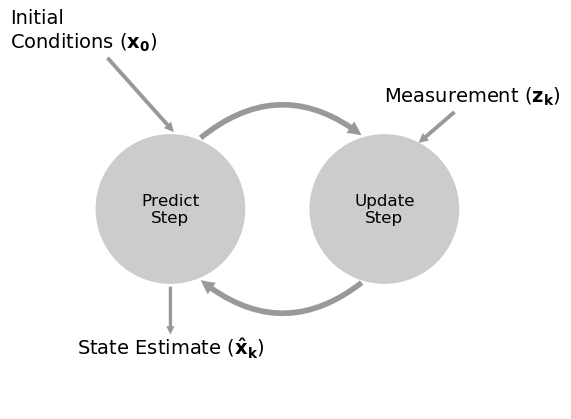

In [20]:
book_plots.predict_update_chart()

让我更正式地介绍一些术语。*系统（system）*是我们想要估计的对象。在本章中，系统是我们试图测量的重量。有的文献中也称之为*对象（plant）*。该术语来自[控制系统理论](https://en.wikipedia.org/wiki/Plant_(control_theory))。

*状态（state）*是我们所关注的当前系统的配置或数值。在本章我们关注的就是重量的测量值。如果我在秤上放100公斤重的东西，那么*状态*就是100公斤。我们根据与我们相关的内容来定义*状态*。与其具体本质含义并不相关，所以我们定义的*状态*不包含这些。但是厂商的质量保证工程师可能会认为*状态*的概念应该包含这些，因为这样可以方便他们可以跟踪和控制制造的过程。

*测量值（measurement）*是系统的测量出的结果。测量值可能不准确，因此可能与状态值不同。

*状态估计（state estimate）*是我们的滤波器对状态的估计。例如，对于100千克的重量，由于传感器误差，我们估计可能是99.327千克。这通常缩写为*估计（estimate）*，本章中已经这样做了。

换句话说，状态应该被认为是系统的实际值。但这个值通常对我们是*隐藏的（hiden）*。如果我测量了一次，你就会得到一个测量值。这个值我们称为*可观察的（observable）*，因为你可以直接观察到这个测量值。相比之下，你永远无法直接观察我的体重，你只能测量它。

这种*隐藏*和*可观察*的概念很重要。任何估计问题都是通过可观察的测量值形成对隐藏的状态的估计。如果您阅读过文献，通常在定义问题时会使用这些术语，因此您需要对它们十分熟悉。

我们使用*过程模型（process model）*对系统进行数学建模。在本章中，我们的过程模型假设我今天的体重是昨天的体重加上我上一次体重的增加值。过程模型不模拟或以其他方式考虑传感器。另一个例子是汽车的过程模型。其过程模型可能是“距离等于速度乘以时间”。这个模型并不完美，因为汽车的速度可以在非零的时间内变化，轮胎可能在道路上滑动等等。*系统误差（system error）*或*过程误差（process error）*就是这个模型中的误差。我们永远无法确切地知道这个误差值，如果我们针对做到了，那我们可以说我们的模型是零误差的。有的文献中会使用*对象模型（plant model）*和*对象误差（plant error）*。你也会看到*系统模型（system model）*这样的表述。其实它们都是指相同的事情。

预测的步骤称为*系统传播（system propagation）*。它使用过程模型来形成新的状态估计。由于过程误差的存在，这种估计并不完美。假设我们按时间跟踪数据，我们说我们将状态传播到未来。 有些文献也将此称为*演进（evolution）*。

更新的步骤称为*测量更新（measurement update）*。 系统传播和测量更新的一次迭代被称为一个*时期（epoch）*。

现在让我们探讨几个不同的领域问题，以便更好地理解这个算法。先思考一个跟踪轨道上的火车的问题。轨道会将列车的位置限制在一定的区域内。此外，火车很大而且很慢。它们需要很长时间才能明显地减速或加速。因此，如果我知道火车在t时刻位于23公里处并以18公里/小时的速度移动，那么我可以非常肯定地预测其在t+1秒的位置。为什么这很重要？假设我们测量其位置的精度只有±250米。火车以每小时18公里的速度移动，也就是每秒5米。那么在t+1秒时，火车将在23.005公里，但测量值可能是22.755公里到23.255公里范围内。因此，如果下一个测量值显示火车位置在23.4公里处，那我们就知道这肯定是不准确的。因为火车在1秒内不能立刻减速，所以即使在t时刻火车司机猛烈踩刹车，火车仍将非常接近23.005公里。如果我们要为这个问题设计一个滤波器（我们将在本章中进一步讨论！），我们希望这个滤波器对预测值给一个高于测量值的权重。

再思考一个抛球的问题。我们知道，当在引力场中，抛出的物体在真空中以抛物线运动。但实际上，抛的球在地球上会受到空气阻力的影响，所以它不会以完美的抛物线运动。棒球投手在投掷曲线球时通常会利用这一原理。假设我们使用计算机视觉技术跟踪体育场内的球（这也是我在工作中所做的事情）。计算机跟踪的准确性可能是适中的，但通过假设它按抛物线运动来预测球的位置也不是非常准确。在这种情况下，我们设计的滤波器应该对测量值和预测值赋予的权重大致相等。

我们再尝试思考如何跟踪飓风中氦气球。我们没有合理的模型可以让我们预测气球的行为，除非是在非常短暂的时间尺度内（例如，我们知道气球不可能在1秒内行进10英里）。在这种情况下，我们将设计的滤波器应该强调测量值的重要性而非预测值。

本书的大部分内容都致力于用数学方法表达上述三段中的关注点，然后找到一个最优解（在某种数学意义上）。在本章中，我们将仅以更直观，但不完美的方式为g和h赋不同的值。但基本思想都是将那些不准确的测量结果与不准确系统行为模型相结合，以获得比任何一种都更好的过滤后的估计。

我们可以将g-h滤波器表述为算法：

**初始化**
1. 初始化滤波器的状态；
2. 初始化我们对状态的假设。

**预测**
1. 根据系统行为预测下一时刻的状态；
2. 调整假设以解释预测的不确定性。

**更新**
1. 获取测量值，并结合假设确定其准确度；
2. 计算测量值和估计值的残差；
3. 在残差的范围内取新的估计值。

在本书中，虽然有一些小的修改，但我们将使用的算法是相同的。

## 符号定义

这里规定一下文章中使用的符号和变量的含义，其中一些已在上面的图表中使用过。测量值通常表示为$z$，这是我们将在本书中使用的（一些文献使用$y$）。下标$k$表示时间步长，因此$z_k$表示是该时间步长的数据。粗体字表示矢量或矩阵。到目前为止，我们只考虑过一个传感器，因此只考虑一个传感器测量值，但一般来说我们可能有*n* 个传感器和n组测量值。$\mathbf{x}$表示我们系统的状态，并且粗体表示它是一个向量。对于我们的体重的实例来说，它表示初始体重和初始体重的增长率，如下所示

$$\mathbf{x} = \begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

在这里，我在x上的加了点的来表示速度。更准确地说，点表示x相对于时间的导数，在这里当然就是速度了。对于体重是62公斤，增长率为0.3
公斤/天，我们可以表示为：

$$\mathbf{x} = \begin{bmatrix}62 \\ 0.3\end{bmatrix}$$

所以，算法很简单。状态初始值为$\mathbf{x_0}$，初始的估计值也是x<sub>0</sub>。然后我们进入一个循环，从时间（或步长）为$k-1$时的值预测时间或步骤为$k$时的状态。然后我们得到测量值$z_k$，并在测量值和预测值之间选择某个点，作为估计值$\mathbf{x}_k$。

## 实验：通用算法

在上面的例子中，我们已经用编码解决我们在本章中讨论过的称重问题。例如，变量名为“weight_scale”，“gain”等。我这样做是为了使算法易于理解，您可以很容易地看懂我们在每个步骤做了什么。但是，这是针对一个特定问题编写的代码，但是算法对于任何问题都是相同的。因此，让我们重写一个通用的代码，让它处理任何问题。我们定义一个这样的方法：

```python
def g_h_filter(data, x0, dx, g, h, dt):
    """
    Performs g-h filter on 1 state variable with a fixed g and h.

    'data' contains the data to be filtered.
    'x0' is the initial value for our state variable
    'dx' is the initial change rate for our state variable
    'g' is the g-h's g scale factor
    'h' is the g-h's h scale factor
    'dt' is the length of the time step 
    """
```

用NumPy数组作为返回值，而不使用列表。通过传递与以前相同的重量数据来测试它，绘制结果，并直观地确定它是否有效。

In [21]:
def g_h_filter(data, x0, dx, g, h, dt):
    pass #  your solution here

# uncomment to run the filter and plot the results
#book_plots.plot_track([0, 11], [160, 172], label='Actual weight')
#data = g_h_filter(data=weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)
#plot_g_h_results(weights, data)

### Solution and Discussion

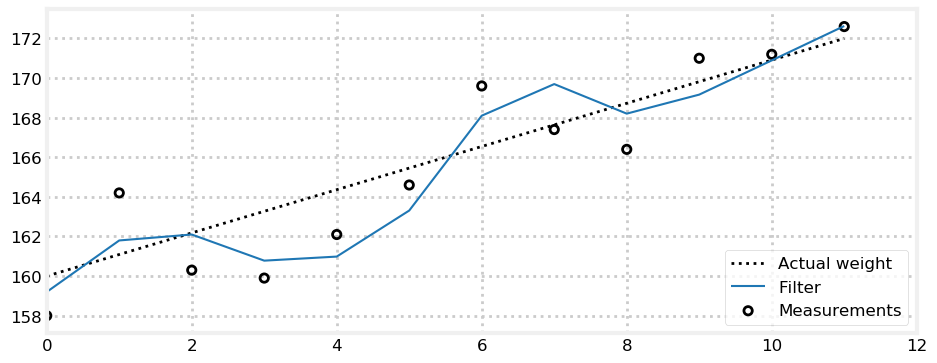

In [22]:
from kf_book.gh_internal import plot_g_h_results
import matplotlib.pylab as pylab

def g_h_filter(data, x0, dx, g, h, dt=1.):
    x_est = x0
    results = []
    for z in data:
        # prediction step
        x_pred = x_est + (dx*dt)
        dx = dx

        # update step
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual
        results.append(x_est)
    return np.array(results)

book_plots.plot_track([0, 11], [160, 172], label='Actual weight')
data = g_h_filter(data=weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)
plot_g_h_results(weights, data)

这应该是很简单的。我只是代码中的体重，增长率等变量名称替换成了定义的`x0`，`dx`等。并没有其他的变化。

## $g$和$h$的选择

g-h滤波器不是一个单独滤波器，它是一系列过滤器的总称。 Eli Brookner在《Tracking and Kalman Filtering Made Easy》一书中列举了11个滤波器，我相信应该更多。不仅如此，每种类型的滤波器都有许多的子类型。每个滤波器的区别在于如何选择$g$和$h$。所以我在这里没有“一刀切”的建议。有些滤波器将$g$和$h$设置为常量，其他过滤波器则动态地改变它们。卡尔曼滤波器就是在每一个时间步长中都动态地改变它们。有的滤波器允许$g$和$h$取一个范围内的任意值，还有的滤波器通过函数约束一个变量依赖于另一个$f（\dot{}），\mbox{where}g=f（h）$。

本书的主题不是整个g-h过滤器系列; 更重要的是，我们对还没有提到的贝叶斯滤波器更感兴趣。 因此，我不会深入讨论$g$和 $h$的选择方式。《Tracking and Kalman Filtering Made Easy》是学习这部分内容的一个很好的资源。如果这让你感到困惑，请认识到卡尔曼滤波器的典型方法是根本不使用g和h。卡尔曼滤波器是一个g-h滤波器，因为它在数学上减少了这种算法。当我们设计卡尔曼滤波器时，我们使用的设计标准可以在数学上减少到g和h，但卡尔曼滤波器形式通常是一种更有效的思考问题的方法。不要担心，如果现在不太清楚，一旦我们开始介绍卡尔曼滤波器理论你就会清楚。

值得注意的是$g$和$g$的变化会对结果产生怎样的影响，因此我们将通过一些例子来研究它。这将使我们深入了解此类过滤器的优势和局限性，并帮助我们了解更复杂的卡尔曼滤波器的特点。

## 创建测量函数

现在让我们编写一个为我们生成噪声数据的函数。在本书中，我将含有噪声信号模拟为信号加上[白噪声](https://en.wikipedia.org/wiki/White_noise)。你可能还没有完全理解白噪声的定义。 实质上，可以将其视为随机变化的数据的信号，时而高和时而低，不存在特定的模式。我们认为它是一个连续的不相关的随机变量，均值为零和方差为常数。如果你理解这一点，你可以学习后面*高斯*章节。如果您对统计理论不了解，则可能无法完成此练习。如果是这样，你可以直接看下面的代码和讨论。

`numpy.random.randn()`可以生成白噪声。我们一个函数接收的参数是初始值，每个步长的变化量，步数以及我们想要添加的噪声量。它应该返回一个数据列表。创建30个点的数据进行测试，使用`g_h_filter()`进行滤波，使用`plot_g_h_results()`绘制结果。

In [23]:
# your code here

### Solution

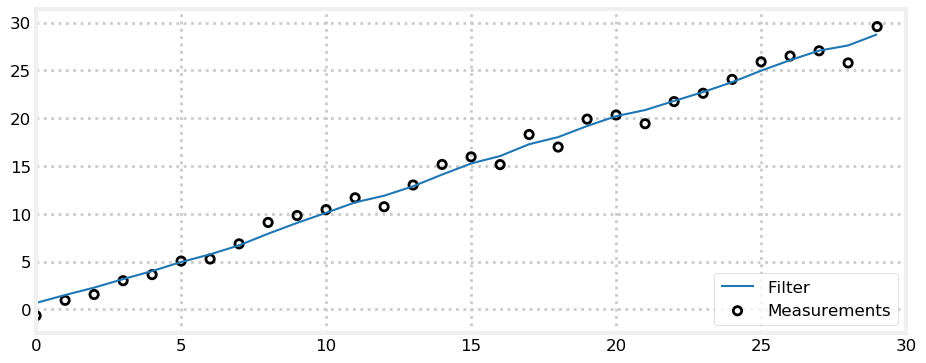

In [24]:
from numpy.random import randn
def gen_data(x0, dx, count, noise_factor):
    return [x0 + dx*i + randn()*noise_factor for i in range(count)]

measurements = gen_data(0, 1, 30, 1)
data = g_h_filter(data=measurements, x0=0., dx=1., dt=1., g=.2, h=0.02)
plot_g_h_results(measurements, data)

### Discussion

函数`randn()`的返回值是以0为中心的随机数，它可能大于零，也可能小于零。它有一个*标准差*——如果您不知道什么叫标准差，请不要担心。我用`randn()`绘制了3000个点，你可以看到这些值以零为中心波动，大多数值的范围在-1到1，但偶尔它们也会超出很多。

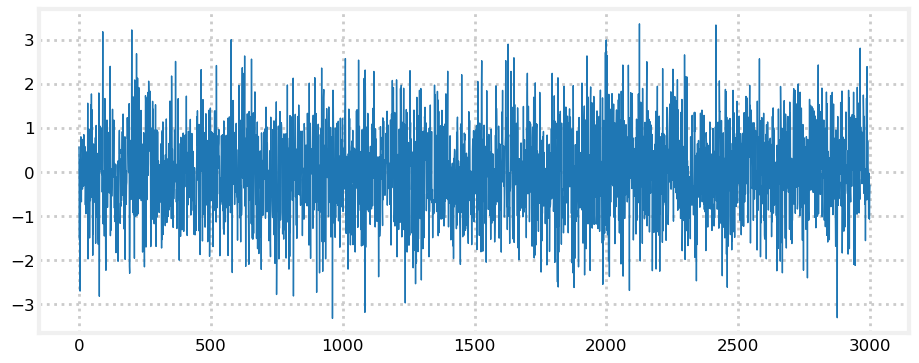

In [25]:
plt.plot([randn() for _ in range(3000)], lw=1);

## 实验：糟糕的初始条件

我们再编写一个使用`gen_data`和`g_h_filter`来对100个数据点过滤的代码，这些数据点从5开始，变化率为2，噪声比例因子为10，g=0.2，h=0.02。但是把x的初始预测值设置为100。

In [26]:
# your code here

### Solution and Discussion

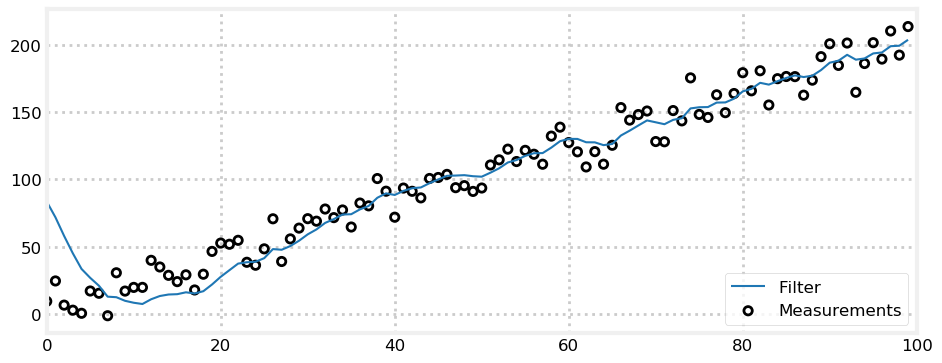

In [27]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=10)
data = g_h_filter(data=zs, x0=100., dx=2., dt=1., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

由于初始的预测值为100是十分错误，所以滤波器的估计值离测量数据十分远。在估计值逐渐接近测量数据之前，您可以看到“rings”。 “ringing”意味着信号以类似正弦的形式形成超调和负调。这是滤波器使用中非常常见的现象，滤波器设计中的许多工作都致力于最小化“ringing”。这是我们还没有准备解决这个问题，但我想先向你展示这一现象。

## 实验：更强的噪音

重新运行相同的测试代码，但这次使用的噪声系数设为100。将初始条件从100改回5来消除初始条件造成的“ring”。

In [28]:
# your code here

### Solution and Discussion

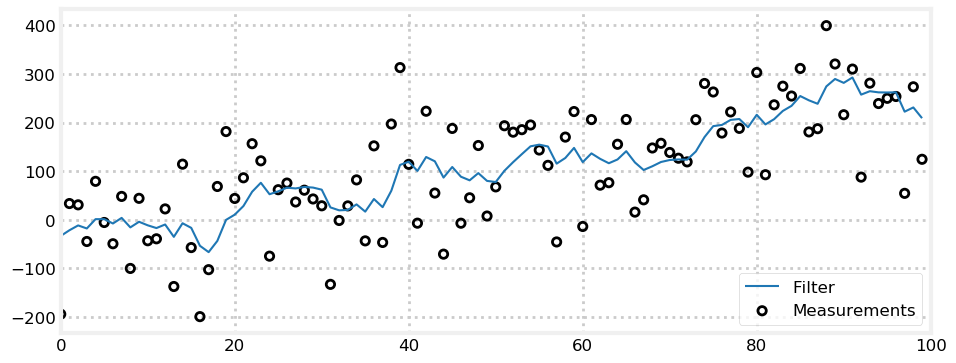

In [29]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=2., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

这对我来说并不是那么完美。但是我们可以看到，虽然滤波后的信号不再是直线直线，但它要比含有噪声的信号的变化地更小。如果我们只绘制过滤后的结果，没有人能猜出来这是从5开始并以每个时间步长增加2的原始信号。 虽然在某些位置，滤波器似乎可以降低噪声，但在其他地方，它似乎仍然会出现超调和负调。

在这一点上，我们无法真正判断这个滤波器的好坏。毕竟我们增加了**很多**噪音，但也许这已经是很不错的一个滤波器了。其实，在后面的章节我们会发现可以有做得更好的滤波器。

## 实验: 加速度的影响

写一个新的数据生成函数，为每个数据点添加一个恒定的加速因子。 换句话说，增加dx来计算每个数据点时，速度（dx）也在不断增加。 将噪音设置为0，$g=0.2$和$h = 0.02$，并绘制结果。尝试解释你所看到的。

In [30]:
# your code here

### Solution and Discussion

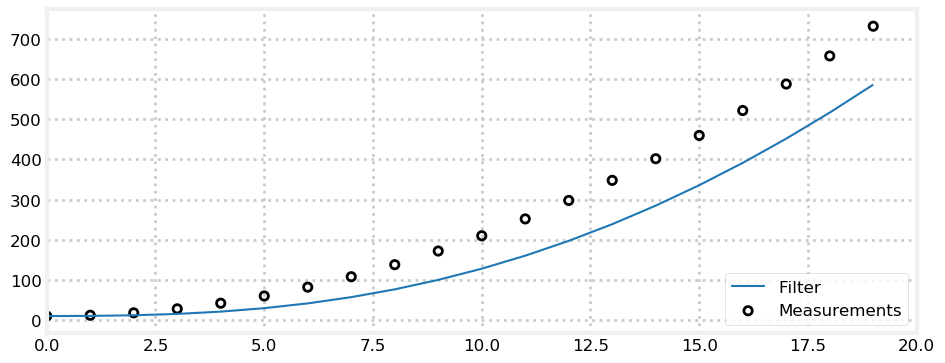

In [31]:
def gen_data(x0, dx, count, noise_factor, accel=0.):
    zs = []
    for i in range(count):
        zs.append(x0 + dx*i + randn()*noise_factor)
        dx += accel
    return zs
   
predictions = []
zs = gen_data(x0=10., dx=0., count=20, noise_factor=0, accel=2.)
data = g_h_filter(data=zs, x0=10., dx=0., g=0.2, h=0.02)
plt.xlim([0, 20])
plot_g_h_results(measurements=zs, filtered_data=data)

从图上可以看出，每个预测值都落后于实际状态。如果你仔细思索，会发现这是合理的。我们的模型假设速度是恒定的。g-h过滤器计算x的一阶导数（我们用$ \dot{x}$来表示导数），但没有考虑二阶导数$ \ddot {x} $。所以我们其实是假设$ \ddot{x} = 0 $。在每个预测步骤中，我们将x的新值预测赋为$ x + \dot {x} * t $。但由于存在加速度，所以预测值必然落后于实际值。然后我们虽然尝试计算新的$ \dot {x} $$，但由于h因子，我们只将$ \dot {x} $$部分地调整了新的速度。 在下一次迭代中，我们依然会再次陷入困境。

请注意，我们无法通过调整g或h来纠正这个问题。这称为系统的*滞后误差（lag error）*或*系统误差（systemic error）*。 这是g-h滤波器的基本属性。也许你已经想出了这个问题的解决方案或方法。正如您所料，很多研究都致力于解决这个问题，我们将在本书中介绍这个问题的各种解决方案。

> The 'take home' point is that the filter is only as good as the mathematical model used to express the system. 

## 实验: 改变因子 $g$

现在让我们来看看改变$g$值会有什么样的效果。在执行这段代码之前，请记住$g$是用来在测量值和预测值之间进行选择的缩放因子。您认为怎样改变$g$的值更有效？变大或者变小？

我们设 `noise_factor=50`， `dx=5`. 画出 $g = 0.1\mbox{， } 0.4,\mbox{， } 0.8$的结果。

In [32]:
# your code here

### Solution and Discussion

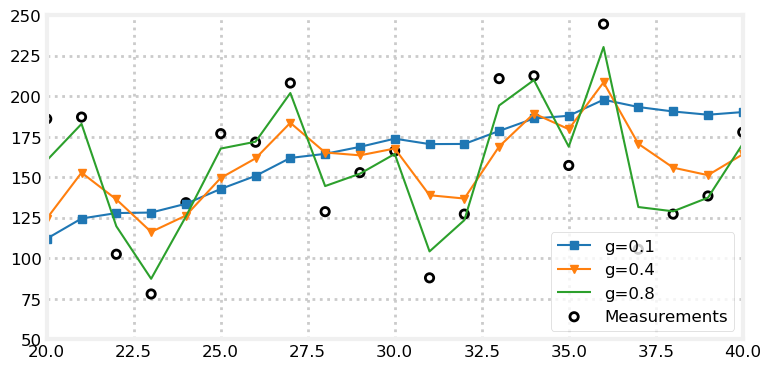

In [33]:
np.random.seed(100)
zs = gen_data(x0=5., dx=5., count=50, noise_factor=50)
data1 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.4, h=0.01)
data3 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.8, h=0.01)

with book_plots.figsize(y=4):
    book_plots.plot_measurements(zs, color='k')
    book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
    book_plots.plot_filter(data2, label='g=0.4', marker='v', c='C1')
    book_plots.plot_filter(data3, label='g=0.8', c='C2')
    plt.legend(loc=4)
    book_plots.set_limits([20, 40], [50, 250])

从图上可以很明显地看出，随着$g$地增大，我们对状态的估计越接近测量值而不是预测值。当$g = 0.8$时，估计值几乎完全跟随信号，并且几乎没有拒绝任何噪声。可能有人会天真地断定$g$应该越小越好，以最大化对噪声抑制。然而，这意味着我们将忽略很多有利于我们预测的测量值。如果信号的变化不是由于噪声而是由于实际的状态发生了变化时，会怎么样？我们来看一下。将前9个时间步长速度设为1，之后的设为0。

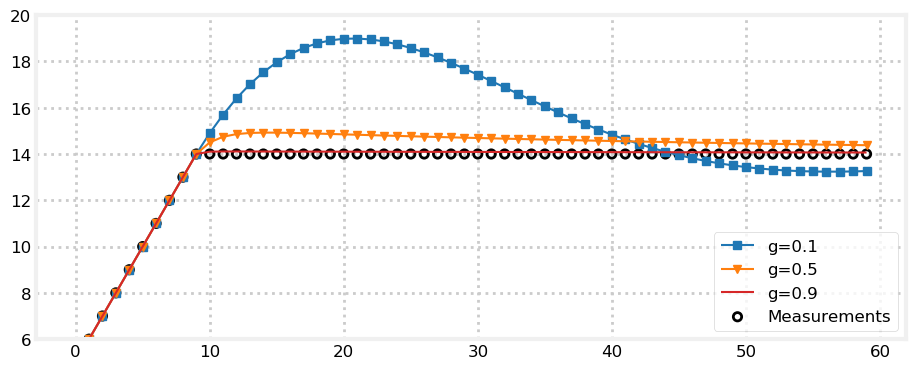

In [34]:
zs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for i in range(50):
    zs.append(14)

data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.5, h=0.01)
data3 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.9, h=0.01)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
book_plots.plot_filter(data2, label='g=0.5', marker='v', c='C1')
book_plots.plot_filter(data3, label='g=0.9', c='C3')
plt.legend(loc=4)
plt.ylim([6, 20]);

在t图上我们可以看到估计值忽略了本身信号的影响。我们不仅滤除了噪音，还滤除了信号的合理变化。

也许我们需要一个'金发姑娘'滤波器，其中$g$不能太大，也不能太小，而是恰到好处？好吧，其实不完全需要这样。如前所述，不同的滤波器根据问题的数学属性以不同的方式选择$g$和$h$。例如，发明出Benedict-Bordner滤波器是为了最小化瞬态误差，就像在这个例子中，速度$\dot{x}$ 发生了跳变。我们不会在本书中讨论这个过滤器，下面有两对不同$g$和$h$的效果图。这样设计出滤波器可以最大限度地减少速度$\dot{x}$ 跳变造成跳跃的瞬态误差，但代价是不适用于速度$\dot{x}$ 其他类型的变化。
> 金发姑娘是童话故事《金发姑娘和三只熊》中满头金发、口味挑剔、偷喝了粥的女主人公，她要求入口的粥不凉不烫刚刚好。



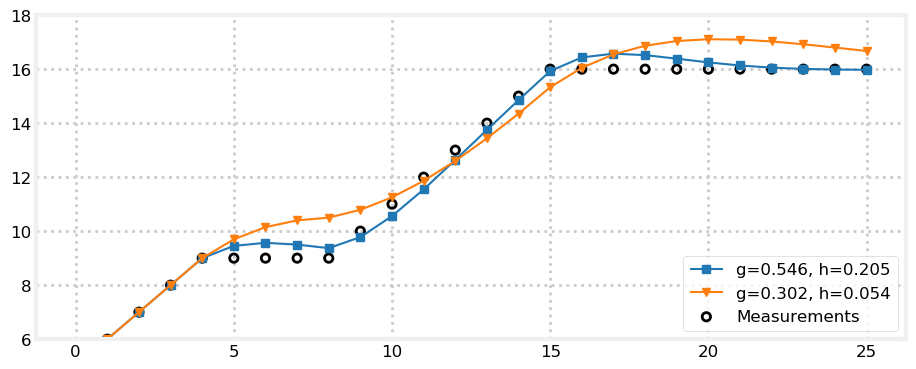

In [35]:
zs = [5,6,7,8,9,9,9,9,9,10,11,12,13,14,
      15,16,16,16,16,16,16,16,16,16,16,16]
data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.302, h=.054)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.546, h=.205)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data2, label='g=0.546, h=0.205', marker='s', c='C0')
book_plots.plot_filter(data1, label='g=0.302, h=0.054', marker='v', c='C1')
plt.legend(loc=4)
plt.ylim([6, 18]);

## 改变因子 $h$

现在让我们保持$g$不变来研究修改h会有怎样的效果。我们知道h取决于我们认为测量的$\dot{x}$对预测值的影响程度。但是，这意味着什么呢？如果我们的信号变化很大（相对于滤波器的时间步长），那么较大的h值将使滤波器迅速对这些瞬态变化作出反应。较小的$h$值则会让滤波器对变化反应地很慢。

我们来观察三个例子。我们有一个无噪音的50个步长的测量值，缓慢地从0变为1。第一个滤波器使用几乎正确的初始值$\dot{x}$和一个较小$h$值。您可以从结果中看到滤波器的输出非常接近信号。第二个过滤器使用不正确的初始值$\dot{x}=2$的。在这里，我们看到过滤器出现“ring”，直到它稳定下来并找到信号。第三个过滤器使用相同的条件，但它的$h= 0.5$。观察“ring”的幅度，你会发现它比第二张图中的小得多，但频率更高。它也比第二个过滤器更快一点稳定，但不没有提前很早。

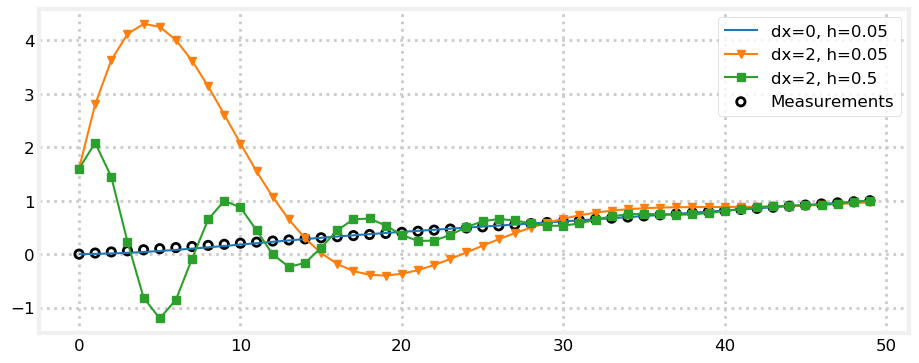

In [36]:
zs = np.linspace(0, 1, 50)

data1 = g_h_filter(data=zs, x0=0, dx=0., dt=1., g=.2, h=0.05)
data2 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.05)
data3 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.5)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='dx=0, h=0.05', c='C0')
book_plots.plot_filter(data2, label='dx=2, h=0.05', marker='v', c='C1')
book_plots.plot_filter(data3, label='dx=2, h=0.5',  marker='s', c='C2')
plt.legend(loc=1);

## 交互示例

对于那些在Jupyter Notebook中运行代码的人，我编写了一个滤波器的交互式版本，这样你就可以看到实时更改$\dot {x} $，$g$和$h$所产生的效果。在您调整$\dot {x}$，$g$和$h$的滑块时，数据将被重新过滤并为您绘制结果。

如果您想测试自己，请尝试在移动滑块之前先阅读下一段并预测结果。

要尝试下面的这些操作，包括将$g$和$h$设置为最小值。看看滤波器跟踪数据的完美程度！其实这只是因为我们完美预测了体重是在增加。将$ \dot {x} $调整为大于5或小于5。滤波器应该偏离数据并且永远不会重新追踪到它。这时开始增加$g$或$h$并查看滤波器是如何快速追踪到数据的。当你单独增加$g$和$h$时，看看估计的曲线有什么区别。你能解释一下差异的原因吗？然后尝试将$g$设置为大于1。您能解释一下结果吗？将$g$恢复到合理的值（例如0.1），然后将$h$的值设的非常大。 你能解释一下这些结果吗？最后，将$g$和$h$置为最大值。

如果你想探索更多的情景，可以将数组`zs`的值更改为上面任何一个图表中使用的值，然后重新运行单元格以查看结果。

In [37]:
from ipywidgets import interact

# my FloatSlider returns an ipywidgets.FloatSlider with
# continuous_update=False. Filtering code runs too slowly
# to instantly react to slider changes.
from kf_book.book_plots import FloatSlider

zs1 = gen_data(x0=5, dx=5., count=100, noise_factor=50)

fig = None
def interactive_gh(x, dx, g, h):
    global fig
    if fig is not None: plt.close(fig)
    fig = plt.figure()
    data = g_h_filter(data=zs1, x0=x, dx=dx, g=g, h=h)
    plt.scatter(range(len(zs1)), zs1, edgecolor='k', 
                facecolors='none', marker='o', lw=1)
    plt.plot(data, color='b')

interact(interactive_gh,           
         x=FloatSlider(value=0, min=-200, max=200), 
         dx=FloatSlider(value=5, min=-50, max=50), 
         g=FloatSlider(value=.1, min=.01, max=2, step=.02), 
         h=FloatSlider(value=.02, min=.0, max=.5, step=.01));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x', max=200.0, min=-200.0),…

## 不要对滤波器说谎

您可以将$g$和$h$设置为任意值。下面是一个尽管存在极端噪音仍能完美运行的滤波器。

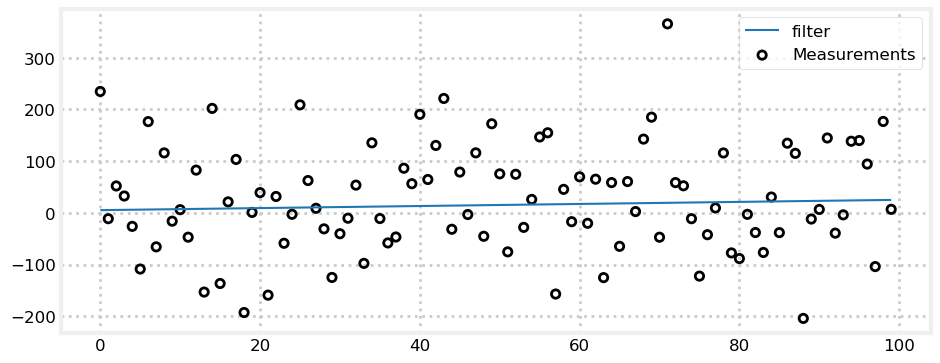

In [38]:
zs = gen_data(x0=5., dx=.2, count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=.2, dt=1., g=0., h=0.)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data, label='filter')
plt.legend(loc=1);

我从非常嘈杂的数据中完美地提取出了一条直线！也许我应该被数学领域著名的菲尔兹奖提名。我是通过将$g$和$h$设置为0才获得这样的结果。为什么这样就可以了呢？因为它使滤波器每次更新估计值时完全忽略了测量值，它只需要根据$ x + \Delta x \Delta t $计算新的位置就可以了。所以，当我们忽略测量结果时，结果当然就是一条直线了。

忽略测量值的滤波器没有实际意义。我知道你永远不会把$g$和$h$都设置为零，但我可以肯定如果你会不小心你将它们设置得低于应有的水平。那样您将始终从测试数据中获得完美的结果。当您尝试对其他数据进行滤波时，您会对结果感到失望，因为您对特定的数据集做了精准的调整。$g$和$h$的值必须反映您正在过滤的系统的实际行为，而不是针对一个特定数据集的行为。在后面的章节中，我们将进一步学习如何做到这一点。现在我只能说要谨慎设置，否则你的测试数据会得到完美的结果，但是一旦切换到真实数据就会得到下面的结果：

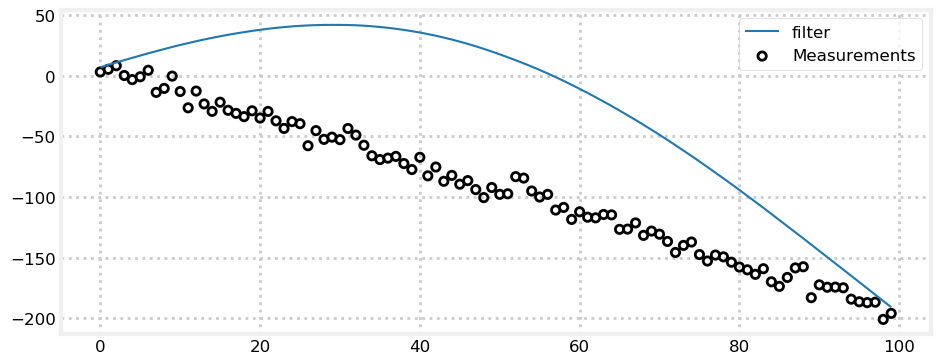

In [39]:
zs = gen_data(x0=5, dx=-2, count=100, noise_factor=5)
data = g_h_filter(data=zs, x0=5., dx=2., dt=1., g=.005, h=0.001)
book_plots.plot_measurements(zs)
book_plots.plot_filter(data, label='filter')
plt.legend(loc=1);

## 定位火车

我们已经准备尝试一个实际的例子了。还记得在本章的前面，我们讨论了火车定位的问题。火车很重，也很慢，它无法快速改变速度。火车行驶在轨道上，所以他们不能改变方向，除非通过减速停止然后逆转方向。因此，如果我们已知火车的近似的位置和速度，那么我们可以准确地预测它在未来很短的时间内的位置。火车不能在一两秒内改变它的速度。

那么让我们为火车来写一个滤波器。火车的位置是指为它在轨道上相对于某个在0kmd 固定点的距离。 即，在1这个位置意味着火车距离固定点1公里。 速度表示为米/秒。我们每秒测量一次位置，误差是±500米。 我们该如何设计我们的滤波器呢？

首先，让我们先模拟没有滤波器的情况。我们假设火车目前在23公里处，并以15米/秒的速度移动。我们可以将其编码为：

```python
pos = 23*1000
vel = 15
```

假设速度没有变化，那么我们可以计算出未来某个时间列车的位置：

```python
def compute_new_position(pos, vel, dt=1):
   return pos + (vel * dt)
```

然后我们向位置信息添加一些随机噪声来模拟测量值。这里我们测量的误差是500米，所以代码如下所示：

```python
def measure_position(pos):
   return pos + random.randn()*500
```
        
我将使用NumPy的`asarray`函数将数据转换为NumPy数组。这样我就可以用'/'对所有的数据元素进行处罚运算。我们把这些整合起来，并绘制出100秒内的模拟的测量值。

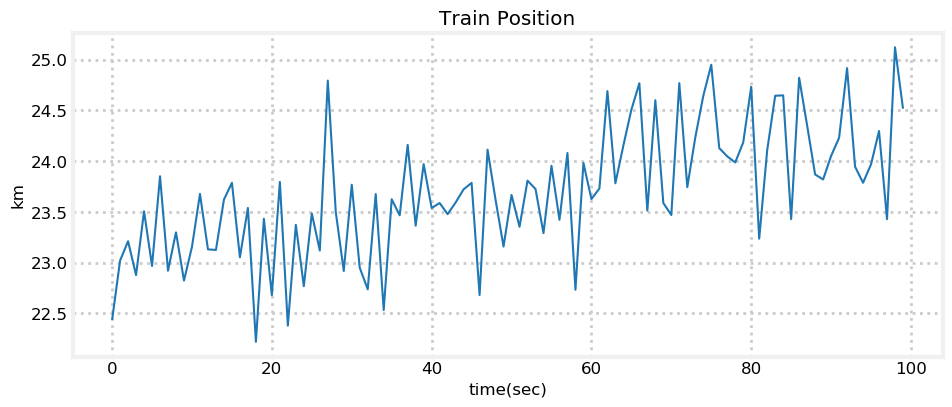

In [40]:
from numpy.random import randn

def compute_new_position(pos, vel, dt=1.):
    """ dt is the time delta in seconds."""
    return pos + (vel * dt)

def measure_position(pos):
    return pos + randn()*500

def gen_train_data(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        zs.append(measure_position(pos))
    return np.asarray(zs)
  
pos, vel = 23.*1000, 15.
zs = gen_train_data(pos, vel, 100)

plt.plot(zs / 1000.)  # convert to km
book_plots.set_labels('Train Position', 'time(sec)', 'km')

从图表中我们可以看出测量的结果十分糟糕。真正的火车是不可能这样移动的。 

那么如果我们想要过滤这些数据，我们应该怎样设置$g$和$h$？我们还没有足够的理论支撑，但让我们先试着凭感觉给个合理的答案。我们现在知道测量结果非常不准确，所以我们不想给它们太多的权重。要做到这一点，我们需要选择一个非常小的$g$。我们也知道火车不能快速地加速或减速，所以我们把$h$也设置为一个很小的值。 例如：

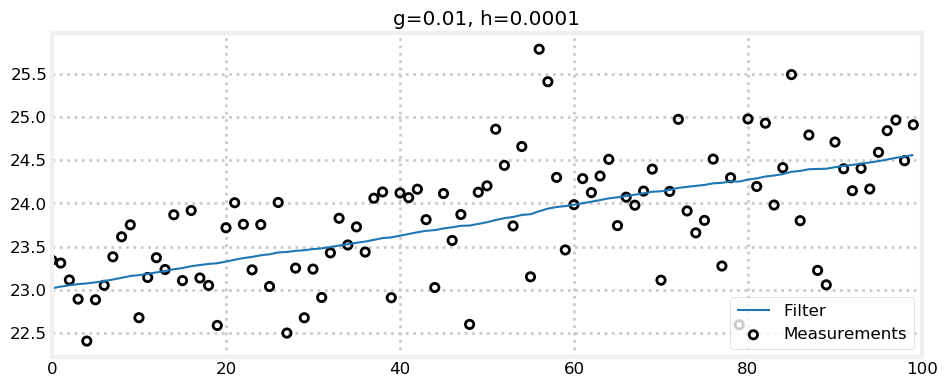

In [41]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

结果看起来很不错，我们把$g$调大一些，看看会有怎样的效果。

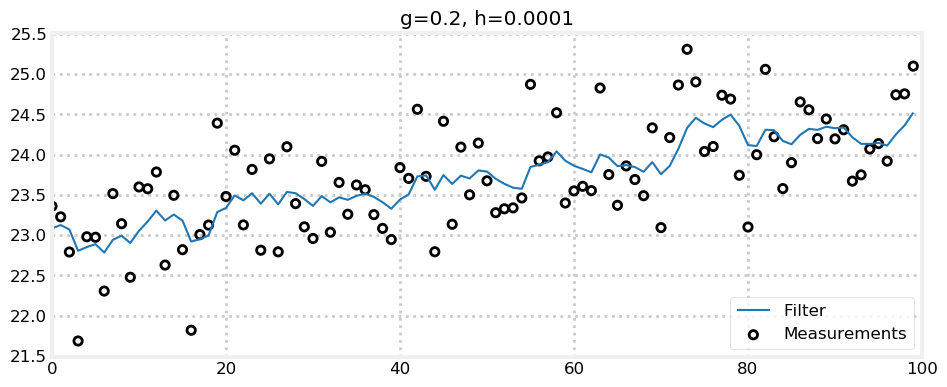

In [42]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.2, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.2, h=0.0001')

当`g=0.2`时，我们可以看到，当火车的位置变化时，估计的位置（包括速度）在非常短的时间内波动很大，真正的火车是不可能做到的。所以我们的`g << 0.2`。

我们再看看$h$会带来的影响。

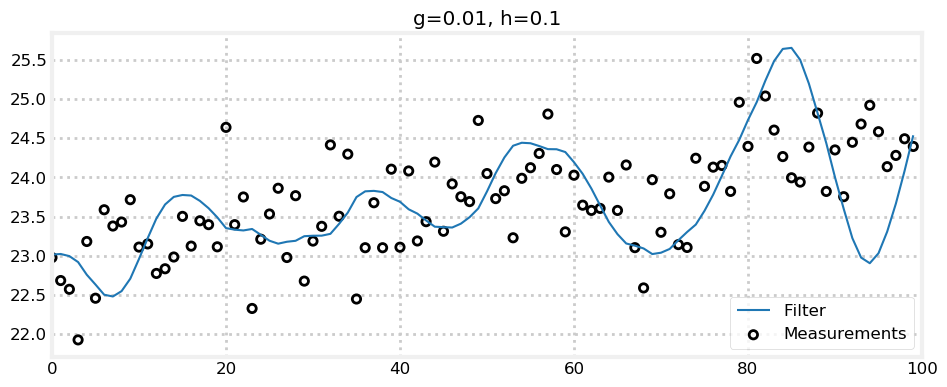

In [43]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=0.01, h=0.1)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.1')

由于$g$很小，火车位置变化得很平稳，但是较大的$h$值使得滤波器对测量值非常敏感。发生这种情况是因为在几秒钟内位置测量值快速的变化意味着速度也发生了很大的变化，较大的$h$值告诉滤波器需要快速响应这些变化。但是火车不能快速改变速度，然而这样的滤波器比火车还有快地改变了速度，因此这个滤波器不能很好地过滤数据。

最后，我们为火车增加一些加速度。我不知道列车实际的加速度有多少，但我们可以设它的加速度为0.2米/秒^ 2。

In [44]:
def gen_train_data_with_acc(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        vel += 0.2
        zs.append(measure_position(pos))
    return np.asarray(zs) 

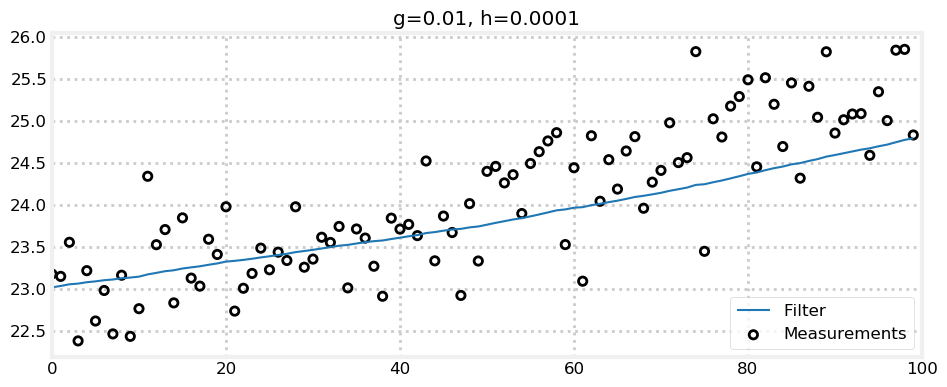

In [45]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

从图上我们可以看到由于加速的原因而滤波器无法再定位列车的位置了。 我们可以修改$h$以让它更好地跟踪，但代价是不太平滑的滤波估计。

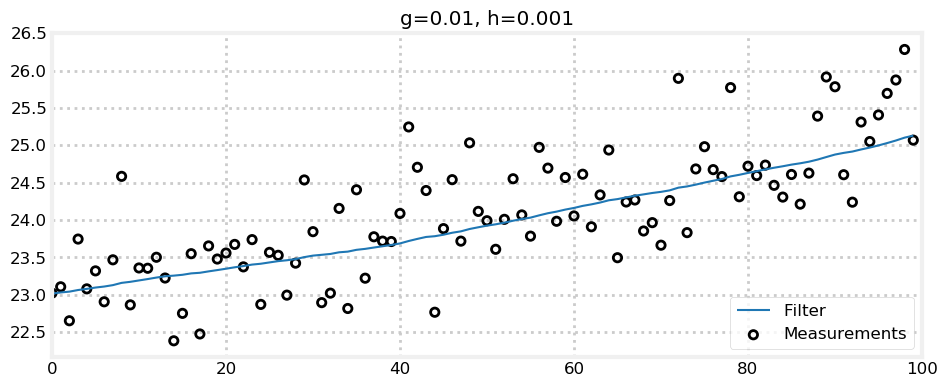

In [46]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.001')

这里有两点可以吸取的教训。首先，使用h值来响应您待建模的速度变化。 但是，更重要的是，在系统处于稳定状态时，你需要在快速准确地响应行为变化和产生理想的输出之间需要进行权衡。如果火车永远不会改变速度，我们可以把$h$设的极小，以避免过滤后的估计值过度受到测量噪声的影响。但是在一个真实的问题中，状态几乎总会发生变化，我们希望快速对它们做出反应。我们对此反应的越快，我们受传感器噪声的影响就越大。

我的目标不是在这里研究g-h滤波器的理论，以便深入了解综合测量值和预测值的滤波方案。关于解决如何选择$g$和$h$的文献很多，并且有最佳方法可以选择它们来实现各种目标。正如我之前解释的那样，在试验这样的测试数据时很容易对滤波器“撒谎”。在随后的章节中，我们将学习卡尔曼滤波器如何以相同的基本但更复杂的数学方式解决这个问题。 

## g-h Filters with FilterPy

[FilterPy](https://github.com/rlabbe/filterpy) is an open source filtering library that I wrote. It has all of the filters in this book, along with others. It is rather easy to program your own g-h filter, but as we progress we will rely on FilterPy more. As a quick introduction, let's look at the g-h filter in FilterPy.

If you do not have FilterPy installed just issue the following command from the command line.

    pip install filterpy
    
Read Appendix A for more information on installing or downloading FilterPy from GitHub.

To use the g-h filter import it and create an object from the class `GHFilter`. 

In [47]:
from filterpy.gh import GHFilter
f = GHFilter(x=0., dx=0., dt=1., g=.8, h=.2)

When you construct the object you specify the initial value and rate of change for the signal (`x` and 'dx'), the time step between updates(`dt`) and the two filter parameter (`g` and `h`). `dx` must have the same units of `x`/`dt` - if `x` is in meters and `dt` is in seconds then `dx` must be in meters per second.

To run the filter call update, passing the measurement in the parameter `z`, which you'll recall is a standard name for measurements in the literature.

In [48]:
f.update(z=1.2)

(0.96, 0.24)

`update()` returns the new value of `x` and `dx` in a tuple, but you can also access them from the object.

In [49]:
print(f.x, f.dx)

0.96 0.24


You can dynamically alter `g` and `h`.

In [50]:
print(f.update(z=2.1, g=.85, h=.15))

(1.965, 0.375)


You can filter a sequence of measurements in a batch.

In [51]:
print(f.batch_filter([3., 4., 5.]))

[[1.965 0.375]
 [2.868 0.507]
 [3.875 0.632]
 [4.901 0.731]]


You can filter multiple independent variables. If you are tracking an aircraft you'll need to track it in 3D space. Use NumPy arrays for `x`, `dx`, and the measurements.

In [52]:
x_0  = np.array([1., 10., 100.])
dx_0 = np.array([10., 12., .2])
               
f_air = GHFilter(x=x_0, dx=dx_0, dt=1., g=.8, h=.2)
f_air.update(z=np.array((2., 11., 102.)))
print(' x =', f_air.x)
print('dx =', f_air.dx)

 x = [  3.8   13.2  101.64]
dx = [8.2  9.8  0.56]


The class `GHFilterOrder` allows you to create a filter of order 0, 1, or 2. A g-h filter is order 1. The g-h-k filter, which we haven't talked about, also tracks accelerations. Both classes have functionality required by real applications, such as computing the Variance Reduction Factor (VRF), which we haven't discussed in this chapter. I could fill a book just on the theory and applications of g-h filters, but we have other goals in this book. If you are interested, explore the FilterPy code and do some further reading.

The documentation for FilterPy is at https://filterpy.readthedocs.org/.

## 总结

我鼓励您尝试通过实验滤波器来理解它是怎么工作的。不应该花太多时间去关注一些表现不佳的$g$和$h$特例。一种特殊的选择可能在一种情况下表现良好，但在另一种情况下表现很差。即使你理解了$g$和$h$的作用，也很难选择合适的值。事实上，你不太可能选择一对对任何问题都是最佳的$g$和$h$的值。过滤器是被*设计*出来的，而不是*特别制定*的。

从某些方面讲，我不想在这里结束这一章，因为我们关于如何选择g和h还有许多可以讲的内容。但是介绍这种形式的g-h滤波器不是本书的目的。 设计卡尔曼滤波器需要你指定一些参数——它们间接地与如何选择$g$和$h$有关，但在设计卡尔曼滤波器时你永远不会直接用到它们。此外，$g$和$h$还将在每个时间段内以非常明显的方式变化。

还有另一个滤波器的特征我们还没有涉及——贝叶斯统计。您可能注意到“贝叶斯”一词出现在本书的标题中; 这不是巧合！现在，让我们先放下$g$和$h$其他未深入理解的知识，来研究一种可以高效的用于滤波的概率推理形式。我们会遇到一个类似g-h滤波器的算法。这次我们将使用了正式的数学模型，允许我们根据多个传感器创建滤波器，准确估计解决方案中的误差，并控制机器人。
